In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.metrics import r2_score
import torch.nn.functional as F
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error

In [ ]:
def generate_time (t_initial, t_final, n_timesteps):
    t_numpy = np.linspace(t_initial, t_final, n_timesteps)
    t_reshape = t_numpy.reshape(1, -1)
    t_torch = torch.tensor(t_reshape, dtype=torch.float32).to(device)
    return t_numpy, t_reshape, t_torch

def zscore(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sd = x.std()
    if sd < eps:
        return x * 0.0
    return (x - mu) / sd

def best_lag_correlation(a, b, max_lag=None, normalize='zscore'):

    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    T = min(len(a), len(b))
    a = a[:T]
    b = b[:T]

    if normalize == 'zscore':
        a_n = zscore(a)
        b_n = zscore(b)
    else:
        a_n = a
        b_n = b

    if max_lag is None:
        max_lag = T - 1

    best_corr = -np.inf
    best_lag = 0
    best_pair = (None, None)


    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:

            a_slice = a_n[-lag:]
            b_slice = b_n[:T+lag]
        elif lag > 0:

            a_slice = a_n[:T-lag]
            b_slice = b_n[lag:]
        else:
            a_slice = a_n
            b_slice = b_n

        if len(a_slice) < 2:
            continue

        corr = np.dot(a_slice, b_slice) / (len(a_slice) - 1)

        if corr > best_corr:
            best_corr = corr
            best_lag = lag

            if lag < 0:
                a_raw = a[-lag:]
                b_raw = b[:T+lag]
            elif lag > 0:
                a_raw = a[:T-lag]
                b_raw = b[lag:]
            else:
                a_raw = a
                b_raw = b
            best_pair = (a_raw, b_raw)

    return {'lag': best_lag, 'corr': best_corr, 'a_seg': best_pair[0], 'b_seg': best_pair[1]}


def smooth_peak(curve, window_length=11, polyorder=3, baseline_ratio=0.01):
    curve = np.asarray(curve)
    smoothed = savgol_filter(curve, window_length=window_length, polyorder=polyorder)

    peak_idx = np.argmax(smoothed)
    peak_val = smoothed[peak_idx]
    threshold = peak_val * baseline_ratio

    # Find start (left of peak)
    start_idx = 0
    for i in range(peak_idx, 0, -1):
        if smoothed[i] < threshold:
            start_idx = i
            break

    # Find end (right of peak)
    end_idx = len(curve) - 1
    for i in range(peak_idx, len(curve)):
        if smoothed[i] < threshold:
            end_idx = i
            break

    # Keep only the main peak region
    cleaned = np.zeros_like(curve)
    cleaned[start_idx:end_idx + 1] = curve[start_idx:end_idx + 1]

    return cleaned

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

# Input generation

In [ ]:
file_path_up ='/content/drive/MyDrive/Multilayer Perceptron/Data/Static_features.csv' # Update to your local path
df_parameters = pd.read_csv(file_path_up)
data = df_parameters.to_numpy()

In [ ]:
n_timesteps = 100000
t_numpy, t_reshape, t_torch = generate_time(1, 3e6, n_timesteps)
M = np.array(data[:,0]).reshape(-1,1)
A = np.array(data[:,3]).reshape(-1,1)
u = np.array(data[:,4]).reshape(-1,1)
x = np.array(data[:,5]).reshape(-1,1)
x_upstream = np.array(x/10).reshape(-1,1)
Q = np.array(data[:,6]).reshape(-1,1)
D = 1
R = 1
theta = 1

In [ ]:
# Calculate concentration using ADE analytical solution
c_upstream = (1e6 * M) / (2 * theta * A * R * np.sqrt(np.pi * D * t_reshape/ R)) * np.exp(-((x_upstream - u * t_reshape / R) ** 2) / (4 * D * t_reshape / R))

# Target generation

## Data Cleaning

In [ ]:
file_path ='/content/drive/MyDrive/Multilayer Perceptron/Data/Experiemental_BTCs.csv' # Update to your local path
df = pd.read_csv(file_path)
df_numeric = df.apply(pd.to_numeric, errors='coerce')
data = df_numeric.to_numpy()
corrected_data = data.copy()
columns = df.columns

In [ ]:
for i in range(0, data.shape[1], 2):
    if i + 1 >= data.shape[1]:
        break  # Ensure we have a pair of columns
    time_col = data[:, i]
    conc_col = data[:, i + 1]

    # Ignore nan values
    valid_indices = ~np.isnan(conc_col)
    time_values = time_col[valid_indices]
    conc_values = conc_col[valid_indices]

    if len(conc_values) == 0:
        continue

    peak_idx = np.argmax(conc_values)

    # Ensure increasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one decreasing value).
    while True:
        fixed = False
        for j in range(1, peak_idx):
            if conc_values[j] < conc_values[j - 1]:  # Not increasing (worng behavior)
                next_valid_idx = j + 1
                while next_valid_idx <= peak_idx and conc_values[next_valid_idx] < conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx <= peak_idx:
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    # Ensure decreasing values before the peak. Iterate until we find the next valid value to interpolate (In case there is more than one increaing value).
    while True:
        fixed = False
        for j in range(peak_idx + 1, len(conc_values) - 1):
            if conc_values[j] > conc_values[j - 1]:  # Not decreasing (wrong behavior)
                next_valid_idx = j + 1
                while next_valid_idx < len(conc_values) and conc_values[next_valid_idx] > conc_values[j - 1]:
                    next_valid_idx += 1

                if next_valid_idx < len(conc_values):
                    conc_values[j:next_valid_idx] = np.linspace(conc_values[j - 1], conc_values[next_valid_idx], (next_valid_idx-j if next_valid_idx-j > 1 else 1))
                    fixed = True
        if not fixed:
            break  # Stop if no more corrections are needed

    corrected_data[valid_indices, i + 1] = conc_values

## Interpolation

In [ ]:
experiment_names = columns[::2]
df_corrected_data = pd.DataFrame(corrected_data, columns=columns)

In [ ]:
# Define delta time in seconds
t_numpy_exp, t_reshape_exp, t_torch_exp = generate_time(1, 3e6, n_timesteps)
common_time = t_numpy_exp/3600

# Interpolate all experiments Into the common time axis
interpolated_conc_corrected = np.zeros((len(common_time), len(experiment_names)))
for i in range(len(experiment_names)):
    time_col = experiment_names[i]
    conc_col = columns[i * 2 + 1]
    experiment_df = df_corrected_data[[time_col, conc_col]].dropna()
    if experiment_df.empty:
        continue
    time_values = experiment_df[time_col].values
    conc_values = experiment_df[conc_col].values

    # Define the interpolation function
    f_interp = interp1d(time_values, conc_values, kind='linear', bounds_error=False, fill_value=0)

    # Interpolate concentrations into the common time
    interpolated_conc_corrected[:, i] = f_interp(common_time)

In [ ]:
c_dowstream = interpolated_conc_corrected.T
c_upstream = c_upstream

# MLP

In [ ]:
input = c_upstream
target = c_dowstream

X = torch.tensor(input,dtype=torch.float32).to(device)
y = torch.tensor(target,dtype=torch.float32).to(device)
print(X.shape)
print(y.shape)

torch.Size([121, 100000])
torch.Size([121, 100000])


In [ ]:
dataset = TensorDataset(X, y)

test_indices = [0,5,14,32,34,49,71,83,95,98,106,45,79]
all_indices = np.arange(len(dataset))
train_indices = list(set(all_indices) - set(test_indices))

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Model, loss, optimizer
input_size = X.shape[1]
output_size = y.shape[1]

model = MLP(input_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-2)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
# Lists to store training losses
train_losses = []

epochs = 500  # Set number of epochs

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track training loss

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)

        mask = batch_y > 1e-1
        filtered_pred = outputs[mask]
        filtered_actual = batch_y[mask]
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #scheduler.step()

    # Compute average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    # Print training loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.6f}')

Epoch 0, Training Loss: 171.921173
Epoch 100, Training Loss: 128.126785
Epoch 200, Training Loss: 16.144976
Epoch 300, Training Loss: 20.831245
Epoch 400, Training Loss: 29.933363


In [ ]:
# Set model to evaluation mode
model.eval()

# Lists to store actual and predicted values
actual_curves = []
predicted_curves = []

with torch.no_grad():  # Disable gradient calculations
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)  # Get predictions

        # Move data to CPU for plotting
        actual_curves.extend(batch_y.cpu().numpy())
        predicted_curves.extend(outputs.cpu().numpy())

actual_curves = np.array(actual_curves)
predicted_curves = np.array(predicted_curves)
predicted_curves[predicted_curves < 0] = 0

In [ ]:
# Cross corelation
max_lag = 1000
use_normalize = 'zscore'

cc_results = []
for i in range(actual_curves.shape[0]):
    a = actual_curves[i]
    b = smooth_peak(predicted_curves[i])
    res = best_lag_correlation(a, b, max_lag=max_lag, normalize=use_normalize)
    cc_results.append(res)

cc_mean_corr = np.mean([r['corr'] for r in cc_results])
print(f"[Cross-Correlation] Correlación media (al mejor lag): {cc_mean_corr:.4f}")

[Cross-Correlation] Correlación media (al mejor lag): 0.2821


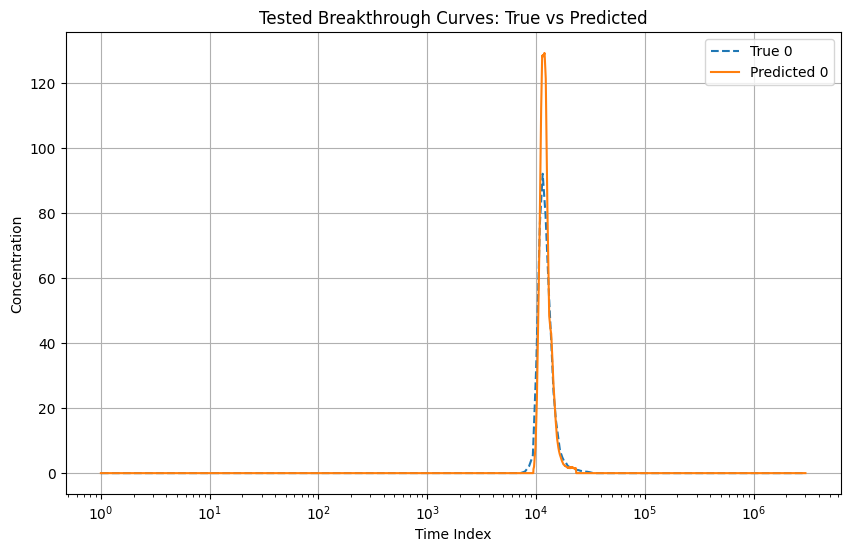

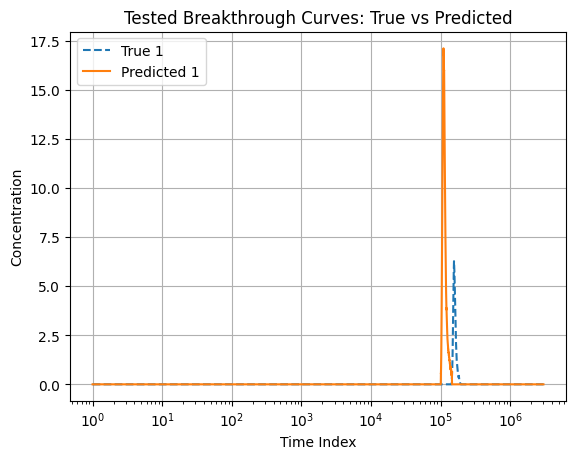

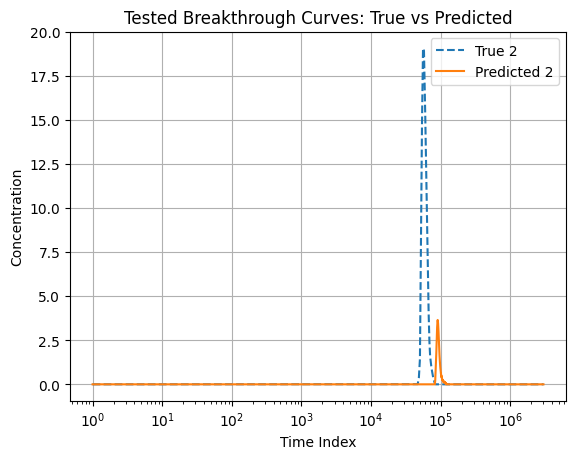

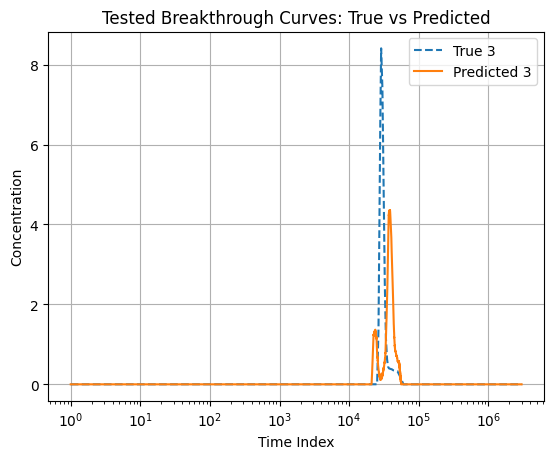

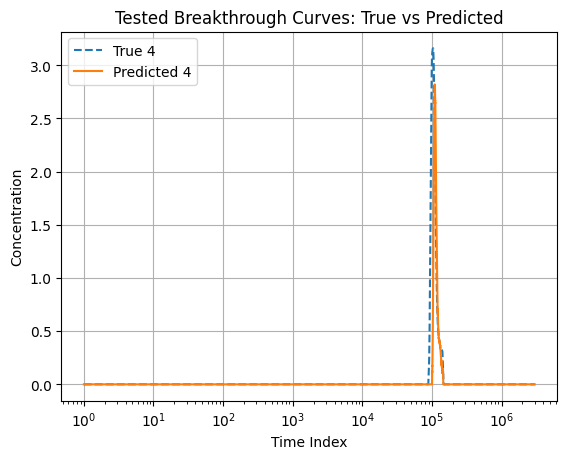

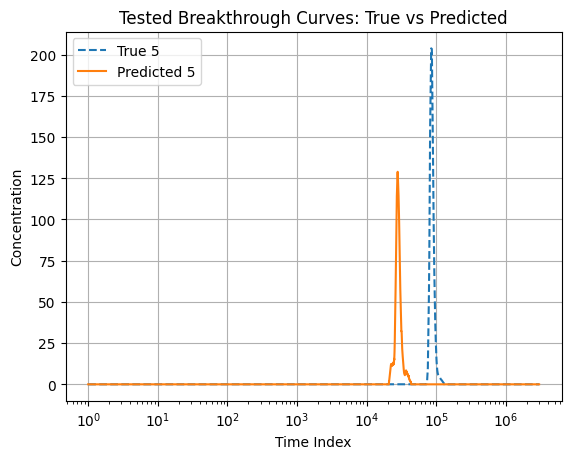

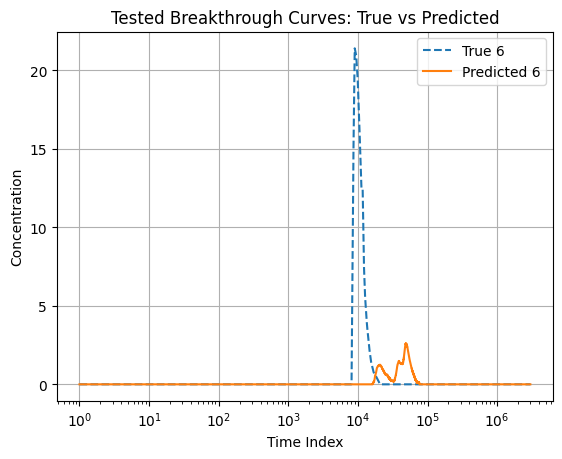

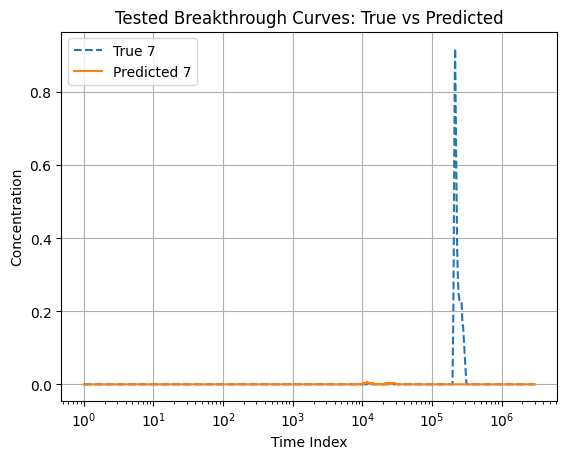

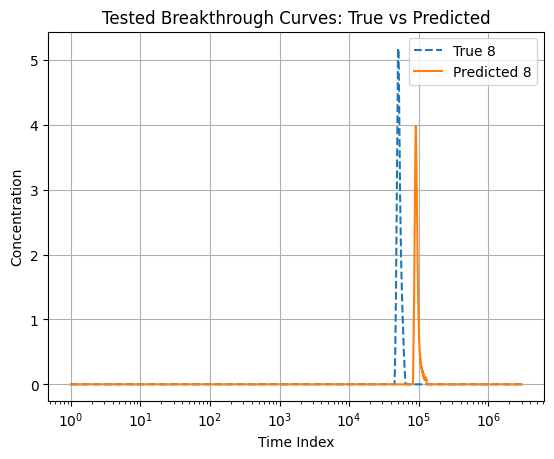

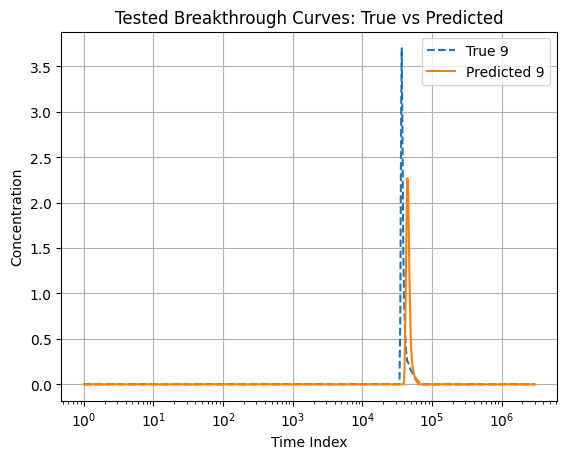

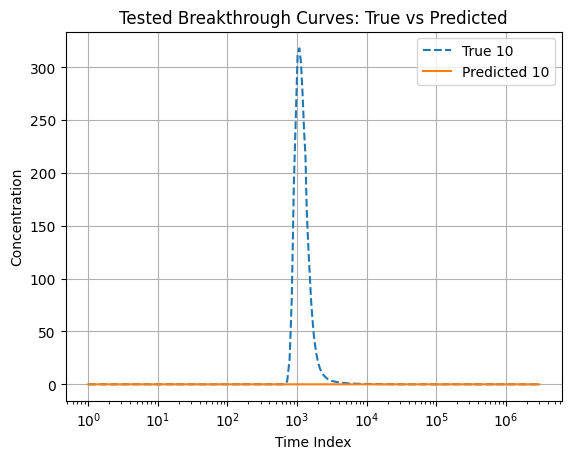

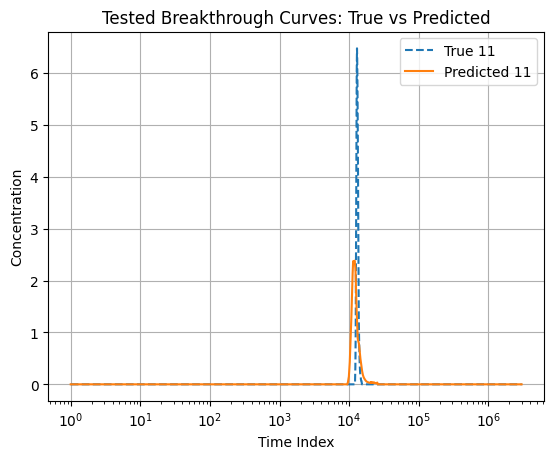

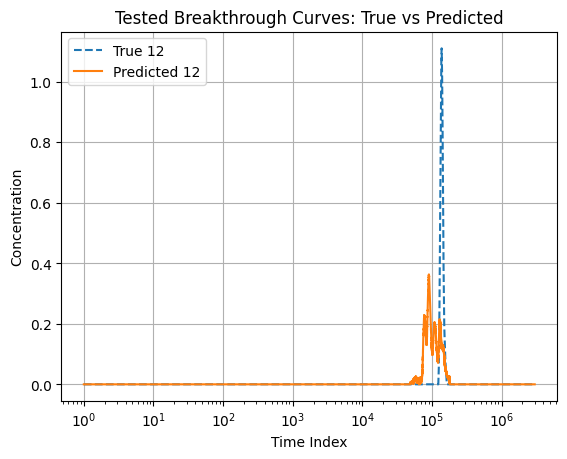

In [ ]:
num_curves_to_plot = len(actual_curves)
plt.figure(figsize=(10, 6))

for i in range(num_curves_to_plot):
    plt.semilogx(t_numpy,actual_curves[i], label=f'True {i}', linestyle='dashed')
    plt.semilogx(t_numpy,smooth_peak(predicted_curves[i]), label=f'Predicted {i}', linestyle='solid')

    plt.xlabel('Time Index')
    plt.ylabel('Concentration')
    plt.title('Tested Breakthrough Curves: True vs Predicted')
    plt.grid(True)
    plt.legend()
    plt.show()

R² Score for Peak Concentration: 0.058172
MAPE (%) respecto a 1:1: 66.86617
Absolute errors: [ 37.108765    10.838589    15.408937     4.048816     0.33929968
  74.87274     18.811632     0.91517395   1.1966112    1.4294922
 318.0021       4.095104     0.74689233]
Bias Ratio: 0.43163884


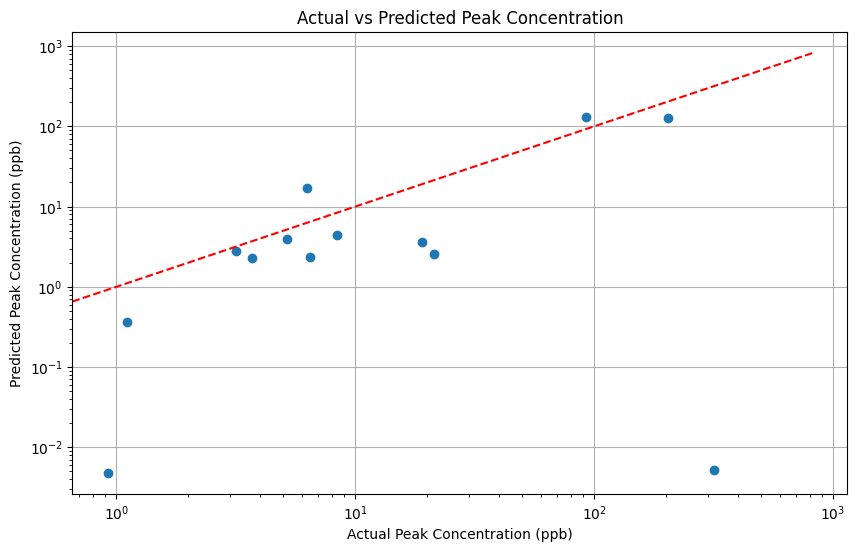

In [ ]:
# Peak concentration
actual_peak = []
predicted_peak = []

for i in range(actual_curves.shape[0]):
    actual_peak.append(np.max(actual_curves[i, :]))
    predicted_peak.append(np.max(predicted_curves[i, :]))

actual_peak = np.array(actual_peak)
predicted_peak = np.array(predicted_peak)

# R2
r2_peak = r2_score(actual_peak, predicted_peak)
print(f'R² Score for Peak Concentration: {r2_peak:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_peak - actual_peak) / actual_peak)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# ABS ERROS
absolute_errors_peak = np.abs(actual_peak - predicted_peak)
print("Absolute errors:", absolute_errors_peak)

# BAIS RATIO
y_true = actual_peak
y_pred = predicted_peak
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print("Bias Ratio:", bias_ratio)

x1 = np.linspace(0, np.max(actual_peak)+500)
y1=x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak,predicted_peak)
plt.plot(x1,y1, linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.title('Actual vs Predicted Peak Concentration')
plt.grid(True)
plt.show()

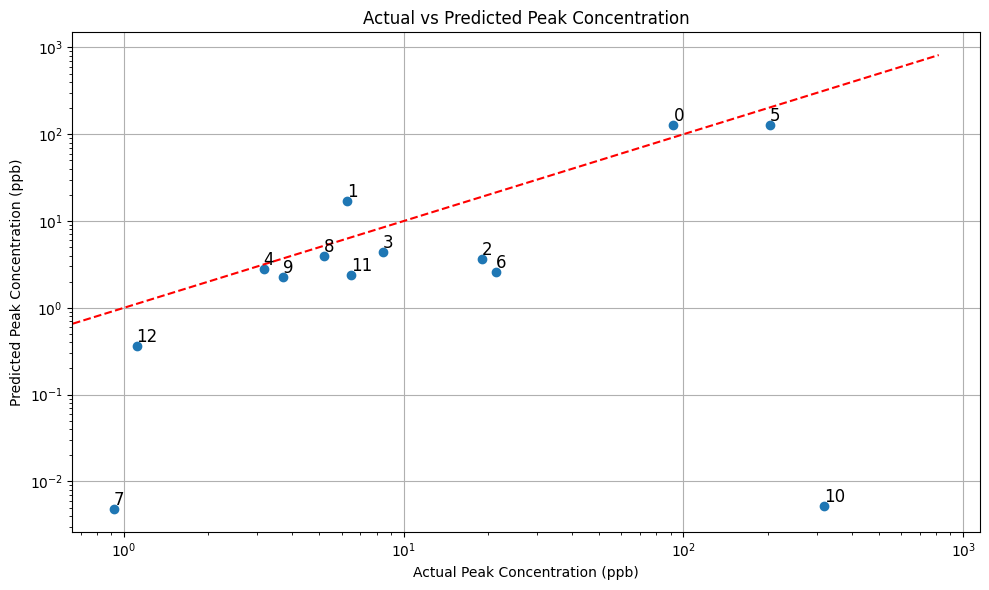

In [ ]:
x1 = np.linspace(0, np.max(actual_peak)+500)
y1 = x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak, predicted_peak)
plt.plot(x1, y1, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_peak, predicted_peak)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.title('Actual vs Predicted Peak Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score for Peak Time: -0.016948
MAPE (%) respecto a 1:1: 143.4438456120794
Absolute errors: [   480.00464005  45720.44196442  34800.33640336   9810.09483095
   6600.06380064  56730.54839548  39810.38483385 204001.97201972
  40200.38860389   7560.07308073  10620.10266103    960.00928009
  47460.45878459]
Bias ratio: 0.773


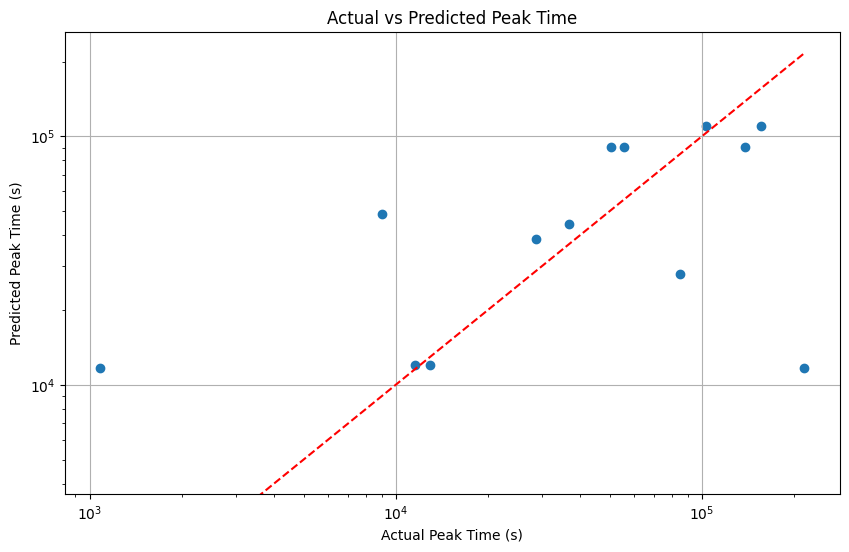

In [ ]:
# Peak time (argmax of each curve)
actual_peaktime = []
predicted_peaktime = []

for i in range(actual_curves.shape[0]):
    actual_peaktime.append(t_numpy[np.argmax(actual_curves[i, :])])
    predicted_peaktime.append(t_numpy[np.argmax(predicted_curves[i, :])])

# Convert to arrays
actual_peaktime = np.array(actual_peaktime)
predicted_peaktime = np.array(predicted_peaktime)

# R2
r2_peaktime = r2_score(actual_peaktime, predicted_peaktime)
print(f'R² Score for Peak Time: {r2_peaktime:.6f}')

#MAPE
mape = np.mean(np.abs((predicted_peaktime - actual_peaktime) / actual_peaktime)) * 100
print("MAPE (%) respecto a 1:1:", mape)

#ABSOLUTE ERROR
absolute_errors_tpeak = np.abs(actual_peaktime - predicted_peaktime)
print("Absolute errors:", absolute_errors_tpeak)

# BAIAS RATIO
y_true = actual_peaktime
y_pred = predicted_peaktime
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x2 = np.linspace(0, np.max(actual_peaktime)+500)
y2=x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime,predicted_peaktime)
plt.plot(x2,y2,linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.title('Actual vs Predicted Peak Time')
plt.grid(True)
plt.show()

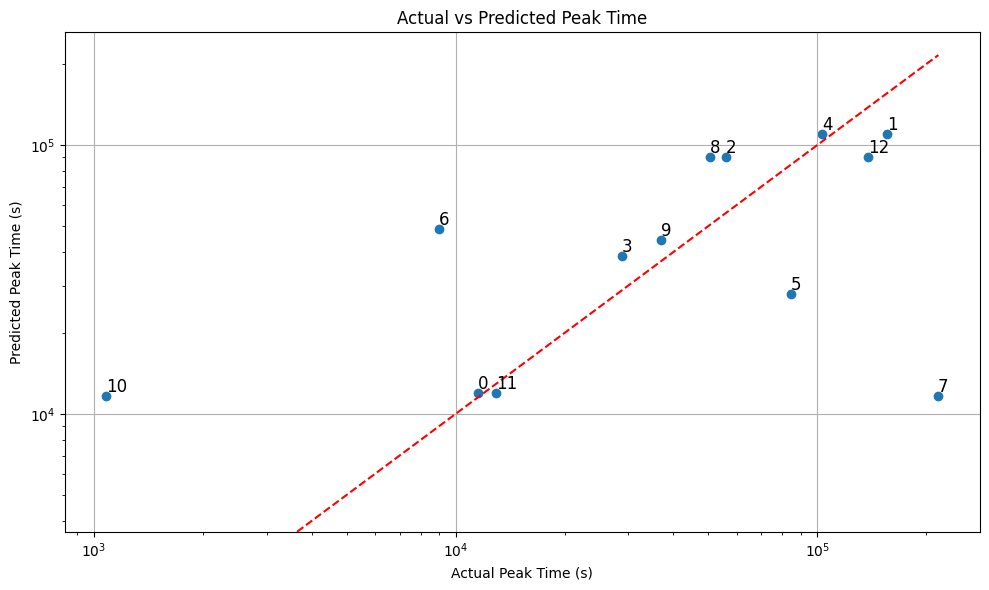

In [ ]:
x2 = np.linspace(0, np.max(actual_peaktime)+500)
y2 = x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime, predicted_peaktime)
plt.plot(x2, y2, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_peaktime, predicted_peaktime)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.title('Actual vs Predicted Peak Time')
plt.grid(True)
plt.tight_layout()
plt.show()



R² Score for M0: 0.338277
MAPE (%) respecto a 1:1: 48.350236081714804
Bias ratio: 0.402


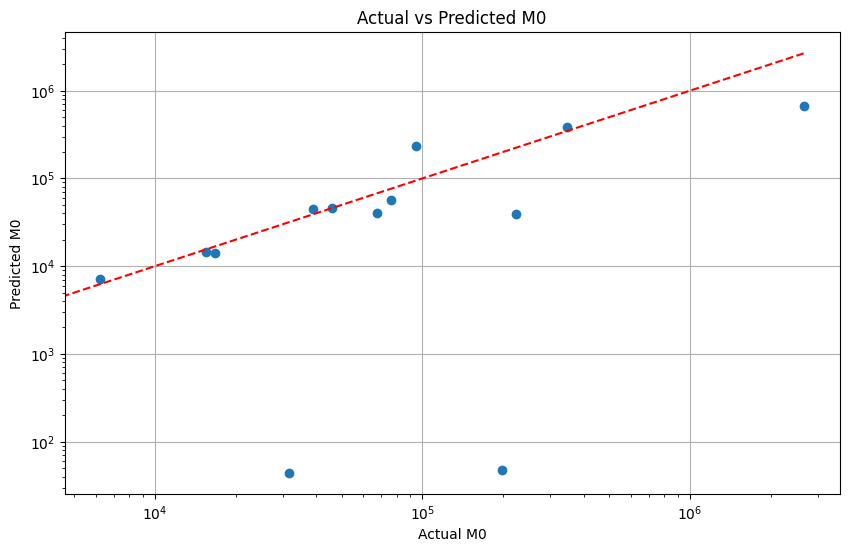

In [ ]:
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves.shape[0]):
    actual_m0.append(np.trapezoid(actual_curves[i,:],t_reshape))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves[i,:]),t_reshape))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+500)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.title('Actual vs Predicted M0')
plt.grid(True)
plt.show()

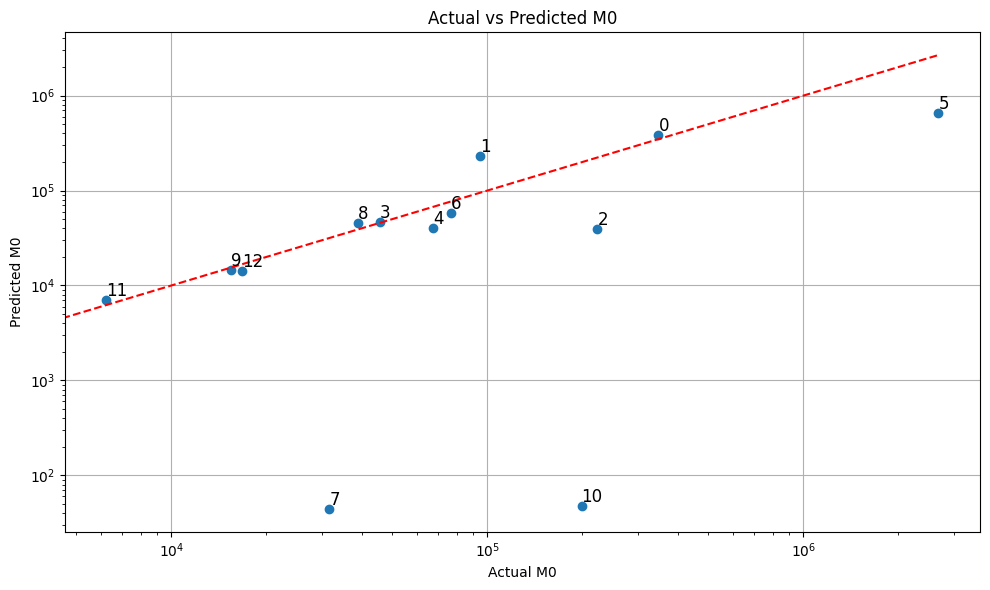

In [ ]:
x3 = np.linspace(0, np.max(actual_m0) + 500)
y3 = x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0, predicted_m0)
plt.plot(x3, y3, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_m0, predicted_m0)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.title('Actual vs Predicted M0')
plt.grid(True)
plt.tight_layout()
plt.show()

R² Score for M1: 0.049784
MAPE (%) respecto a 1:1: 67.28260925799172
Bias ratio: 0.241


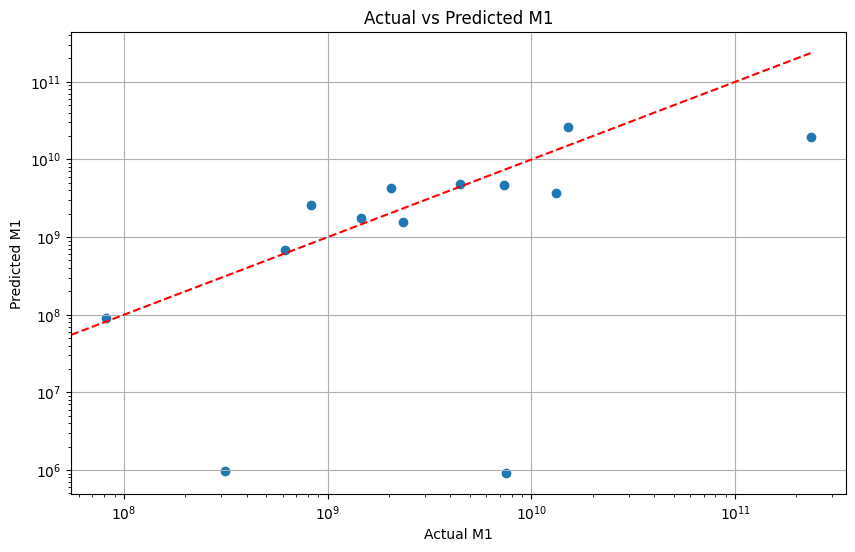

In [ ]:
actual_m1 = []
predicted_m1 = []

for i in range(actual_curves.shape[0]):
    actual_moment = actual_curves[i,:]*t_reshape
    predicted_moment = smooth_peak(predicted_curves[i,:])*t_reshape

    actual_m1.append(np.trapezoid(actual_moment,t_reshape))
    predicted_m1.append(np.trapezoid(predicted_moment,t_reshape))

actual_m1 = np.array(actual_m1)
predicted_m1 = np.array(predicted_m1)

# R2
r2_m1 = r2_score(actual_m1,predicted_m1)
print(f'R² Score for M1: {r2_m1:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m1 - actual_m1) / actual_m1)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m1
y_pred = predicted_m1
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x4 = np.linspace(0, np.max(actual_m1)+500)
y4=x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1,predicted_m1)
plt.plot(x4,y4,linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.title('Actual vs Predicted M1')
plt.grid(True)
plt.show()

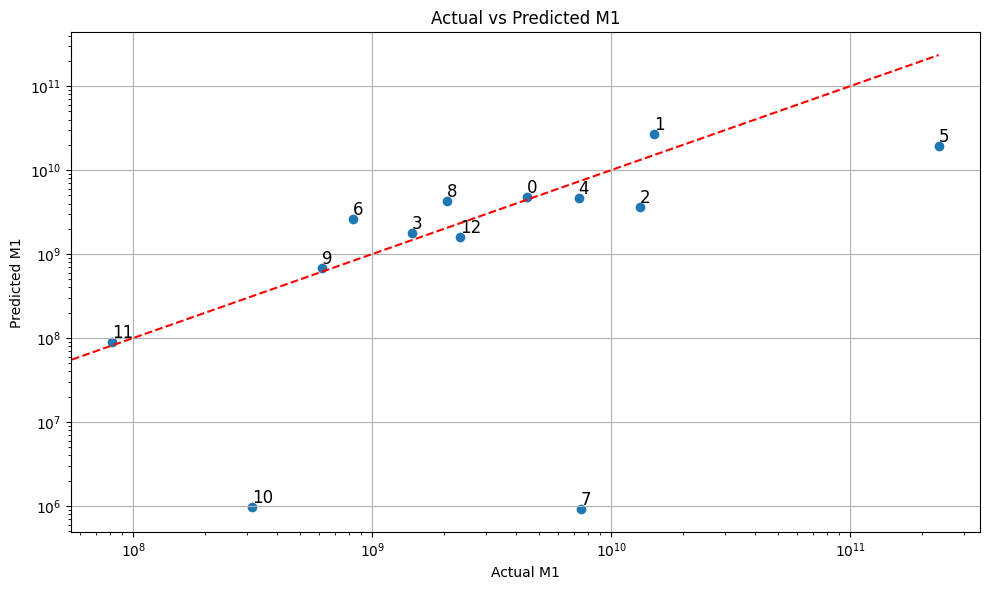

In [ ]:
x4 = np.linspace(0, np.max(actual_m1) + 500)
y4 = x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1, predicted_m1)
plt.plot(x4, y4, linestyle='--', color='r')
for i, (x, y) in enumerate(zip(actual_m1, predicted_m1)):
    plt.text(x, y, str(i), fontsize=12, ha='left', va='bottom')

plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.title('Actual vs Predicted M1')
plt.grid(True)
plt.tight_layout()
plt.show()